In [1]:
import random

import numpy as np
import torch
from torch.utils.data.dataloader import default_collate

from settings import EXPERIMENTS_DIR
from experiment import Experiment
from utils import to_device, load_weights, load_embeddings, create_embeddings_matrix
from vocab import Vocab
from train import create_model
from preprocess_train import load_dataset, create_dataset_reader

In [2]:
def create_vocab(instances):
    vocab = Vocab([Vocab.PAD_TOKEN, Vocab.START_TOKEN, Vocab.END_TOKEN, Vocab.UNK_TOKEN, ])
    vocab.add_documents([inst['sentence'] for inst in instances])

    style_vocab = Vocab()
    style_vocab.add_document([inst['style'] for inst in instances])

    return vocab, style_vocab



In [73]:
exp_id = './train.32igr6n1' #英語
# exp_id = './train.xvdnqtke' #日本語

# Load everything

In [74]:
exp = Experiment.load(EXPERIMENTS_DIR, exp_id)

In [75]:
exp.config

TrainConfig(model_class=<class 'models.Seq2SeqMeaningStyle'>, preprocess_exp_id='preprocess.d785lil4', embedding_size=300, hidden_size=256, dropout=0.2, scheduled_sampling_ratio=0.5, pretrained_embeddings=True, trainable_embeddings=True, meaning_size=128, style_size=128, lr=0.005, weight_decay=1e-07, grad_clipping=5, D_num_iterations=10, D_loss_multiplier=1, P_loss_multiplier=10, P_bow_loss_multiplier=1, use_discriminator=True, use_predictor=True, use_predictor_bow=True, use_motivator=True, use_gauss=True, num_epochs=500, batch_size=64, best_loss='loss')

In [32]:
exp.config.preprocess_exp_id

'preprocess.d785lil4'

In [76]:
# preprocess_exp = Experiment.load(EXPERIMENTS_DIR, exp.config.preprocess_exp_id)
preprocess_exp = Experiment.load(EXPERIMENTS_DIR, "preprocess.odjd0wsl")
dataset_train, dataset_val, dataset_test, vocab, style_vocab, W_emb = load_dataset(preprocess_exp)

In [77]:
dataset_reader = create_dataset_reader(preprocess_exp.config)

In [78]:
len(vocab)

9418

In [79]:
model = create_model(exp.config, vocab, style_vocab, dataset_train.max_len, W_emb)

In [80]:
exp.experiment_dir

PosixPath('data/experiments/train.32igr6n1')

In [81]:
load_weights(model, exp.experiment_dir.joinpath('best.th'))

In [82]:
model = model.eval()

## Predict

In [83]:
def create_inputs(instances):
    if not isinstance(instances, list):
        instances = [instances,]
        
    if not isinstance(instances[0], dict):
        sentences = [
            dataset_reader.preprocess_sentence(dataset_reader.spacy( dataset_reader.clean_sentence(sent)))
            for sent in instances
        ]
        
        style = list(style_vocab.token2id.keys())[0]
        instances = [
            {
                'sentence': sent,
                'style': style,
            }
            for sent in sentences
        ]
        
        for inst in instances:
            inst_encoded = dataset_train.encode_instance(inst)
            inst.update(inst_encoded)            
    
    
    instances = [
        {
            'sentence': inst['sentence_enc'],
            'style': inst['style_enc'],
        } 
        for inst in instances
    ]
    
    instances = default_collate(instances)
    instances = to_device(instances)      
    
    return instances

In [84]:
def get_sentences(outputs):
    predicted_indices = outputs["predictions"]
    end_idx = vocab[Vocab.END_TOKEN]
    
    if not isinstance(predicted_indices, np.ndarray):
        predicted_indices = predicted_indices.detach().cpu().numpy()

    all_predicted_tokens = []
    for indices in predicted_indices:
        indices = list(indices)

        # Collect indices till the first end_symbol
        if end_idx in indices:
            indices = indices[:indices.index(end_idx)]

        predicted_tokens = [vocab.id2token[x] for x in indices]
        all_predicted_tokens.append(predicted_tokens)
        
    return all_predicted_tokens

In [85]:
sentence =  ' '.join(dataset_val.instances[0]['sentence'])
# sentence =  ' '.join(dataset_train.instances[0]['sentence'])

In [86]:
sentence

'i love these girls ( and my hair ! )'

In [87]:
inputs = create_inputs(sentence)

In [88]:
inputs

{'sentence': tensor([[   4, 1256, 1601, 2922,   72,   23,  167, 1775,  171,   77,    2,    0,
             0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0'),
 'style': tensor([0], device='cuda:0')}

In [89]:
outputs = model(inputs)

In [90]:
outputs["logits"].shape

torch.Size([1, 20, 9418])

In [91]:
loss = 0
for i in range(20):
    sentence =  ' '.join(dataset_val.instances[i]['sentence'])
    inputs = create_inputs(sentence)
    outputs = model(inputs)
    loss += outputs["loss"]
    if outputs["loss"]<20:
        print(i)
        print("入力",sentence)
        print(outputs["loss"])
        print("出力"," ".join(get_sentences(outputs)[0]))

0
入力 i love these girls ( and my hair ! )
tensor(4.9778, device='cuda:0', grad_fn=<NllLossBackward0>)
出力 i love this place .
1
入力 do not give this course a chance !
tensor(4.2571, device='cuda:0', grad_fn=<NllLossBackward0>)
出力 do not waste your time .
2
入力 marilyn is the best in the business , hands down .
tensor(4.8201, device='cuda:0', grad_fn=<NllLossBackward0>)
出力 three is a great .
3
入力 the food is incredible .
tensor(1.6922, device='cuda:0', grad_fn=<NllLossBackward0>)
出力 the food is great and the service is great .
4
入力 it 's sad because their menu has many options and it actually sounds appetizing .
tensor(5.7886, device='cuda:0', grad_fn=<NllLossBackward0>)
出力 it 's a great place to the . .
5
入力 the everything bagel has just enough of , well , everything .
tensor(5.0334, device='cuda:0', grad_fn=<NllLossBackward0>)
出力 the best part is the .
6
入力 again , i am not sure if the sauce was prepared in - house .
tensor(4.5711, device='cuda:0', grad_fn=<NllLossBackward0>)
出力 overall 

In [92]:
loss/20

tensor(4.7660, device='cuda:0', grad_fn=<DivBackward0>)

In [93]:
sentences = get_sentences(outputs)

In [52]:
' '.join(sentences[0])

'「 、 、 の の の の の の の の の の の の の'

### Swap style

In [94]:
possible_styles = list(style_vocab.token2id.keys()) #['negative', 'positive']

In [95]:
possible_styles

['negative', 'positive']

In [96]:
sentences0 = [s for s in dataset_val.instances if s['style'] == possible_styles[0]]
sentences1 = [s for s in dataset_val.instances if s['style'] == possible_styles[1]]

In [97]:
for i in np.random.choice(np.arange(len(sentences0)), 5):
    print(i, ' '.join(sentences0[i]['sentence']))

1820 after asking to pay i was yelled at very loud by the owner .
1386 then he had the nerve to ask me if we still wanted it .
537 it took number minutes for one of the worst meals ever .
145 number more minutes to get plates .
185 lon 's is no longer the dining gem as it was in the past .


In [98]:
for i in np.random.choice(np.arange(len(sentences1)), 5):
    print(i, ' '.join(sentences1[i]['sentence']))

559 phoenix body works is awesome and i highly recommend , we will be back !
44 the food selection was great .
2081 great service , amazing food .
2671 its trashy and has all walks of life ... .
1467 the noodles were great though .


#### Swap

In [99]:
target0 = np.random.choice(np.arange(len(sentences0)))
target1 = np.random.choice(np.arange(len(sentences1)))

In [100]:
print(' '.join(sentences0[target0]['sentence']))

it tasted bad .


In [101]:
print(' '.join(sentences1[target1]['sentence']))

the selection is fantastic and all the food is high quality .


In [102]:
inputs = create_inputs([
    sentences0[target0],
    sentences1[target1],
])

In [103]:
z_hidden = model(inputs)

In [104]:
z_hidden['style_hidden'].shape

torch.Size([2, 128])

In [105]:
z_hidden

{'decoder_hidden': tensor([[-10.0000, -10.0000, -10.0000, -10.0000, -10.0000,  10.0000, -10.0000,
           10.0000,  10.0000,  10.0000,  10.0000,  10.0000, -10.0000,  10.0000,
          -10.0000, -10.0000, -10.0000, -10.0000, -10.0000, -10.0000, -10.0000,
          -10.0000, -10.0000, -10.0000,  10.0000, -10.0000,  10.0000,  10.0000,
          -10.0000,  10.0000,  10.0000, -10.0000, -10.0000, -10.0000, -10.0000,
           -2.3903, -10.0000, -10.0000, -10.0000, -10.0000, -10.0000, -10.0000,
           10.0000,  10.0000,  10.0000,  10.0000, -10.0000, -10.0000,  10.0000,
           10.0000, -10.0000,  10.0000, -10.0000, -10.0000, -10.0000, -10.0000,
          -10.0000,  10.0000,  10.0000, -10.0000, -10.0000, -10.0000,  10.0000,
           10.0000,  10.0000, -10.0000,  10.0000,  10.0000, -10.0000,  10.0000,
          -10.0000,  10.0000,  10.0000,  10.0000, -10.0000,  10.0000, -10.0000,
           10.0000, -10.0000, -10.0000, -10.0000,  10.0000,  10.0000,  -9.2134,
          -10.0000,  1

In [106]:
z_hidden['meaning_hidden'].shape

torch.Size([2, 128])

In [107]:
original_decoded = model.decode(z_hidden)

In [108]:
original_sentences = get_sentences(original_decoded)

In [109]:
print(' '.join(original_sentences[0]))
print(' '.join(original_sentences[1]))

it really is a great place to the . .
the selection is great and the staff is always friendly .


In [110]:
z_hidden_swapped = {
    'meaning_hidden': torch.stack([
        z_hidden['meaning_hidden'][0].clone(),
        z_hidden['meaning_hidden'][1].clone(),        
    ], dim=0),
    'style_hidden': torch.stack([
        z_hidden['style_hidden'][1].clone(),
        z_hidden['style_hidden'][0].clone(),        
    ], dim=0),
}

In [111]:
swaped_decoded = model.decode(z_hidden_swapped)

In [112]:
swaped_sentences = get_sentences(swaped_decoded)

In [113]:
print(' '.join(original_sentences[0]))
print(' '.join(original_sentences[1]))
print()
print(' '.join(swaped_sentences[0]))
print(' '.join(swaped_sentences[1]))

it really is a great place to the . .
the selection is great and the staff is always friendly .

just a great place .
good food , great service .


# Visualization

In [114]:
import matplotlib.pyplot as plt

In [115]:
import pandas as pd
from_num=0
to_num=300
sentences = [" ".join(line['sentence']) for line  in dataset_val.instances[from_num:to_num]]
# gold(style) label listを作成する
gold = [line['style'] for line  in dataset_val.instances[from_num:to_num]]

# sentences = []
# gold = []
# for i in range(1000):
#     line = dataset_val.instances[i]
#     if i != '<unk>':
#         sentences.append(" ".join(line['sentence']))
#         gold.append(line['style'])

df = pd.DataFrame({0 : pd.Series(gold),
                   1 : pd.Series(sentences)})
print('styleとsentenceのリストを表示します')
print(df.head(10))

# modelの出力からstyle embeddingを取り出す
inputs_features = []
for sentence in df[1]:
    if sentence != '<unk>':
        # inputs_features.append(create_inputs(sentence, dataset_train, dataset_reader, style_vocab))
        inputs_features.append(create_inputs(sentence))
print(inputs_features[:5])
# inputs_features = [create_inputs(sentence, dataset_train, dataset_reader, style_vocab) for sentence in df[1]]
# outputs_features = []
# for line in inputs_features:
#     outputs = model(line)
#     outputs_features.append(outputs)
#     line = Variable(line, volatile=True)
outputs_features = [model(line) for line in inputs_features]
print(outputs_features[0])

# style_embedを抽出する
style_embed = [line['style_hidden'].to('cpu').detach().numpy().copy() for line  in outputs_features]
meaning_embed = [line['meaning_hidden'].to('cpu').detach().numpy().copy() for line  in outputs_features]

styleとsentenceのリストを表示します
          0                                                  1
0  positive               i love these girls ( and my hair ! )
1  negative                 do not give this course a chance !
2  positive  marilyn is the best in the business , hands do...
3  positive                           the food is incredible .
4  negative  it 's sad because their menu has many options ...
5  positive  the everything bagel has just enough of , well...
6  negative  again , i am not sure if the sauce was prepare...
7  positive  they are famous for their pies but i love the ...
8  positive   best mexican food i have ever eaten in my life .
9  negative   an overall extremely lackluster dining service .


/home/yuta_m/.pyenv/versions/3.6.10/envs/keigo_adversarial/lib/python3.6/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


[{'sentence': tensor([[   4, 1256, 1601, 2922,   72,   23,  167, 1775,  171,   77,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0'), 'style': tensor([0], device='cuda:0')}, {'sentence': tensor([[ 140,   32,  298,   69, 1747,   24, 1558,  171,    2,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0'), 'style': tensor([0], device='cuda:0')}, {'sentence': tensor([[8301,   16,   12, 1068,   68,   12,   82,   14,  950,  261,    8,    2,
            0,    0,    0,    0,    0,    0,    0,    0]], device='cuda:0'), 'style': tensor([0], device='cuda:0')}, {'sentence': tensor([[ 12, 384,  16, 560,   8,   2,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0]], device='cuda:0'), 'style': tensor([0], device='cuda:0')}, {'sentence': tensor([[  41,  303, 1298,  668,  196,  272,   84,  224,  226,   23,   41,  229,
         2060, 1448,    8,    2,    0,    0,    0,    0]], device='cuda:0'), 'sty

In [116]:
    style_embeds = np.array(style_embed)
    print('style_embedsのサイズです')
    print(style_embeds.shape)
    style_embeds_sq=np.squeeze(style_embeds)
    print('style_embeds_sqのサイズです')
    print(style_embeds_sq.shape)

style_embedsのサイズです
(300, 1, 128)
style_embeds_sqのサイズです
(300, 128)


In [117]:
meaning_embeds = np.squeeze(np.array(meaning_embed))

In [118]:
meaning_embeds.shape

(300, 128)

In [119]:
style_embed_csr =csr_matrix(style_embeds_sq)

NameError: name 'csr_matrix' is not defined

In [120]:
from sklearn.manifold import TSNE

In [121]:
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30)
X_style = tsne.fit_transform(style_embeds_sq)
ddf = pd.concat([df, pd.DataFrame(X_style, columns = ['col1', 'col2'])], axis = 1)
gold_list = ddf[0].unique()
print('gold_listの中身です')
print(gold_list)

gold_listの中身です
['positive' 'negative']


In [129]:
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30)
X_mean = tsne.fit_transform(meaning_embeds)
ddf = pd.concat([df, pd.DataFrame(X_mean, columns = ['col1', 'col2'])], axis = 1)
gold_list = ddf[0].unique()
print('gold_listの中身です')
print(gold_list)

gold_listの中身です
['positive' 'negative']


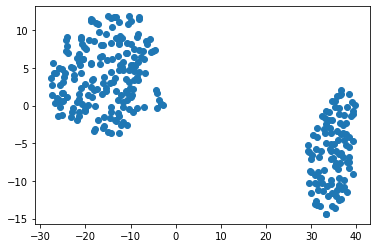

In [61]:
plt.scatter(X_mean[:,0],X_mean[:,1])

In [375]:
ddf

,0,1,col1,col2
0,normal,お 伺い し た 院 が 、 その 時点 で 最も 必要 な アクション の 提案 を 行な...,36.362606,-6.508626
1,normal,し て おく ほう が 無難 か 。,-12.426080,-1.070418
2,normal,ちょうど タルタル ♂ の 種族 装備 が ゲット できる 時間 帯 で 、 ３５ 人 くら...,-23.615273,7.895673
3,normal,どう に も なり ませ ん 。,-11.358288,3.783835
4,normal,そんな 純粋 ( 変態 ？ ) な 動機 で 作成 さ れ た 『 妄 撮 モーサツ 』 の,-25.008032,6.692950
...,...,...,...,...
295,normal,はじめ から フィールド が 存在 し て い た なら 、 僕 も フィールド で 遊ぶ ...,35.886929,4.853009
296,normal,最近 ヒーローズ と いう テレビ の 番組 を 見 て て 、 大好き 。,-10.226772,1.142594
297,normal,[ 1 ] 外貨 預金 は 高 金利 だ と 一般 に 思わ れ て い ます が 、,34.457619,3.929468
298,keigo,落下 、 水没 、 分解 、 改造 、 使用 上 の 誤り 等 、 お 客 様 の 故意,-10.627301,0.307508


In [64]:
!pip install plotly

  Using cached plotly-5.6.0-py2.py3-none-any.whl (27.7 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


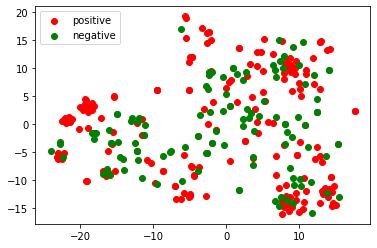

In [122]:
colors =  ["r", "g"]
fig,ax = plt.subplots()
# plt.figure(figsize = (30, 30))
for i , v in enumerate(gold_list):
    tmp_df = ddf[ddf[0] == v]
    plt.scatter(tmp_df['col1'],  
                tmp_df['col2'],
                label = v,
                color = colors[i])
    plt.legend()

In [132]:
import plotly.express as px
fig = px.line(ddf, x="col1", y="col2", color=0,hover_data=[1])
fig.update_traces(mode="markers")
# fig.write_html("tsne.html")
fig.show()
